# Final Project Playground

This is just a python notebook where I (Diana) will be exploring the problem more in depth, so as to be able to experiment with a variety of things separate from what is in the baseline.

## Import Libraries and Get Data

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend
from keras.optimizers import SGD

from sklearn.decomposition import PCA

In [4]:
# Get Kaggle Training Data only
kaggle_competition_training_data = pd.read_csv('data/training/training.csv')
print("Kaggle Competition Training Data Shape: ", kaggle_competition_training_data.shape)
kaggle_competition_training_data.head(1)

Kaggle Competition Training Data Shape:  (7049, 31)


left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   

   right_eye_inner_corner_y  \
0                 37.389402   

                         ...                          nose_tip_y  \
0                        ...                           57.066803   

   mouth_left_corner_x  mouth_left_corner_y  mouth_right_corner_x  \
0            61.195308            79.970165             28.614496   

   mouth_right_corner_y  mouth_center_top_lip_x  mouth_center_top_lip_y  \
0             77.388992               43.312602               72.935459   

   mouth_center_bottom_lip_x  mouth_center_bottom_lip_y  \
0                  43.130707                  84.485774   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  

[1 rows x 31 columns]

In [7]:
# Convert Training data to useful format
# WARNING: This takes quite some time to run
# Loop to re-store all image values in comma separated list object
training_image_list = []
for i in range(len(kaggle_competition_training_data["Image"])):
    training_image_list.append(kaggle_competition_training_data["Image"][i].split(" "))

# reshaping the image list object into array
training_image_array = np.array(training_image_list, dtype = 'float')
len(training_image_array)

7049

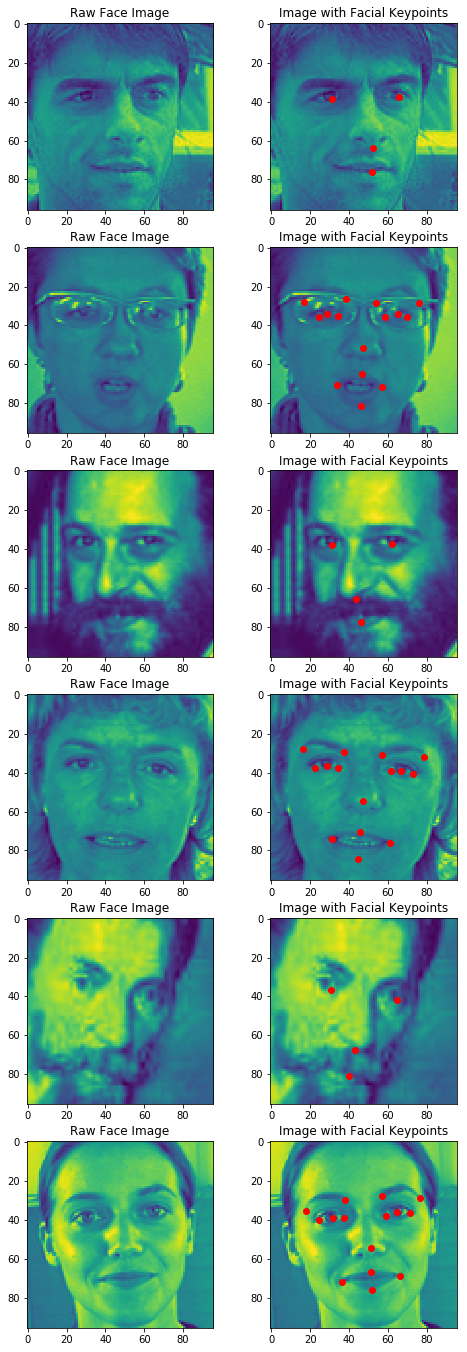

In [20]:
# plotting sample images (good & bad) and associated facial points into 96x96 after reshaping them
feature_list = list(kaggle_competition_training_data)
feature_list.remove("Image")

examples = [7019, 10, 7020, 14, 7021, 23]
num_examples = len(examples)

# Plot raw image (hardcode to the 10th image)
f, images = plt.subplots(num_examples,2, figsize=(8,4*num_examples))

for j in range(0, num_examples):
    example_idx = examples[j]
    #images[j, 0].imshow(training_image_array[example_idx].reshape(96,96), cmap='gray') 
    images[j, 0].imshow(training_image_array[example_idx].reshape(96,96))
    images[j, 0].set_title("Raw Face Image")

    # Plot image with keypoints
    #images[j, 1].imshow(training_image_array[example_idx].reshape(96,96), cmap='gray')
    images[j, 1].imshow(training_image_array[example_idx].reshape(96,96))
    images[j, 1].set_title("Image with Facial Keypoints")
    for i in feature_list[::2]:
        images[j, 1].plot(kaggle_competition_training_data[i[:-1]+'x'][example_idx], 
                          kaggle_competition_training_data[i[:-1]+'y'][example_idx], 'o', color='red')

## Exploration 1: Only look at examples with non-null facial keypoints

For the first phase of exploration, will try to develop a model that solves the problem where we have all 15 facial keypoints defined. Next phase of exploartion will involve looking at images that are missing facial keypoints and how to do feature engineering there. 

### Data Preparation (for non-null data)

In [33]:
# Creating new training dataset with no null values (should be 2140 observations)
isnulls_total = kaggle_competition_training_data[kaggle_competition_training_data.isnull().any(axis=1)]
temp_df = kaggle_competition_training_data
isnulls_column = list(isnulls_total.index)
kaggle_competition_training_data_nonull = temp_df.drop(isnulls_column)

In [35]:
# Convert images and labels to formats needed for model development (will be used throughout)

def ConvertToImagesArray(original_kaggle_data):
    # Extract images 
    new_images_data_list = []
    for i in original_kaggle_data["Image"].index:
        new_images_data_list.append(original_kaggle_data["Image"][i].split(" "))
        
    # Reshaping the image list object into array
    new_images_data = np.array(new_images_data_list, dtype = 'float')
    return new_images_data

def ConvertToLabelsArray(original_kaggle_data):
    # Extract Labels and reshape to array
    new_labels_data = np.array(original_kaggle_data.drop(['Image'], axis=1), dtype='float')
    return new_labels_data

# Format Images data and Labels data for model development
all_images_nonull = ConvertToImagesArray(kaggle_competition_training_data_nonull)

# Get labels separately into array
all_labels_nonull = ConvertToLabelsArray(kaggle_competition_training_data_nonull)

# Print off final dimensions of data:
print("Dimensions of All Non-null 96x96 Facial Images Array:     " + str(all_image_nonull.shape))
print("Dimensions of All Non-null Facial Keypoints Labels Array: " + str(all_labels_nonull.shape))

Dimensions of All Non-null 96x96 Facial Images Array:     (2140, 9216)
Dimensions of All Non-null Facial Keypoints Labels Array: (2140, 30)


In [60]:
# Split data with non-null keypoints into training & test
# Note: Dev set implicitly split at model training time
train_images_nonull, test_images_nonull, \
train_labels_nonull, test_labels_nonull = train_test_split(all_images_nonull, all_labels_nonull, test_size=0.2, random_state=42, shuffle=True)

print("Dimensions of Training Data: " + str(train_images_nonull.shape))
print("Dimensions of Test Data: " + str(test_images_nonull.shape))

Dimensions of Training Data: (1712, 9216)
Dimensions of Test Data: (428, 9216)


### Modeling (for non-null data)

In [87]:
def PlotModelLoss(model_history):
    train_loss = model_history["loss"]
    dev_loss = model_history["val_loss"]
    
    plt.plot(train_loss)
    plt.plot(dev_loss)

In [85]:
# Creating a baseline model with no convolutions (two-layer NN)
model_1_0 = Sequential()
model_1_0.add(Dense(100,input_dim=train_images_nonull.shape[1]))
model_1_0.add(Activation('relu'))
model_1_0.add(Dense(30))

# Since we're being evaluated with RMSE, use mean_squared_error loss
model_1_0.compile(loss='mean_squared_error', optimizer='adam')

model_1_0.summary()

hist_1_0 = model_1_0.fit(train_images_nonull, train_labels_nonull, epochs=100, validation_split=0.1,verbose=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 100)               921700    
_________________________________________________________________
activation_18 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 30)                3030      
Total params: 924,730
Trainable params: 924,730
Non-trainable params: 0
_________________________________________________________________


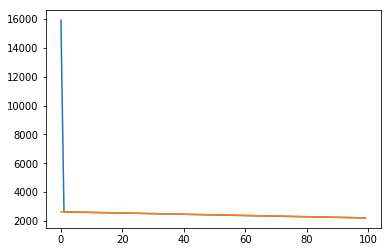

In [88]:
PlotModelLoss(hist_1_0.history)

## Exploration 2: Dealing with the null keypoints

In [91]:
kaggle_competition_training_data.isna().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [97]:
# Convert data to appropriate format
all_images = ConvertToImagesArray(kaggle_competition_training_data)
all_labels = ConvertToLabelsArray(kaggle_competition_training_data)

In [153]:
# Get column names to note which keypoints are missing and which are present
keypoint_names = kaggle_competition_training_data.columns[0:30]
print(keypoint_names)

# Construct encoding vectors for entries with missing values
encodings_list = []
for r in range(0, len(all_labels)):
    row = all_labels[r]
    
    # Encode 0 if missing, 1 if present
    encoding_vec = ['0' if np.isnan(kp) else '1' for kp in row] 
    encoding = ''.join(encoding_vec)
    
    # Only collect those with missing values
    if ('0' in encoding):
        missing_kp_names = ', '.join([i[0] for i in keypoint_names[np.argwhere(np.isnan(row))]])
        present_idx = [i for i in range(0,30) if i not in np.argwhere(np.isnan(row))]
        present_kp_names = ', '.join([i for i in keypoint_names[present_idx]])
        #print(present_idx)
        print("\nMISSING: " + missing_kp_names)
        print("\nPRESENT: " + present_kp_names)
        print("\nENCODING: " + encoding + "\n\n")
        encodings_list.append(encoding)
        
encodings = np.array(encodings_list, dtype = 'str')
values, counts = np.unique(encodings, return_counts=True)
encoding_counts = pd.DataFrame({'encoding':values, 'counts':counts})
encoding_counts

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

MISSING: mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, ri

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, nose_tip_x, nose_tip_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111111111111111111001111111111



MISSING: right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_c

MISSING: left_eye_outer_corner_x, left_eye_outer_corner_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, left_eye_inner_corner_x, left_eye_inner_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, nose_tip_x, nose_tip_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111111001111111111111111111111



MISSING: left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, left_eye_inner_corner_x, left_

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inne

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_


ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, 

MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_end_x, left_eyebrow_inner_end_y, left_eyebrow_outer_end_x, left_eyebrow_outer_end_y, right_eyebrow_inner_end_x, right_eyebrow_inner_end_y, right_eyebrow_outer_end_x, right_eyebrow_outer_end_y, mouth_left_corner_x, mouth_left_corner_y, mouth_right_corner_x, mouth_right_corner_y, mouth_center_top_lip_x, mouth_center_top_lip_y

PRESENT: left_eye_center_x, left_eye_center_y, right_eye_center_x, right_eye_center_y, nose_tip_x, nose_tip_y, mouth_center_bottom_lip_x, mouth_center_bottom_lip_y

ENCODING: 111100000000000000001100000011



MISSING: left_eye_inner_corner_x, left_eye_inner_corner_y, left_eye_outer_corner_x, left_eye_outer_corner_y, right_eye_inner_corner_x, right_eye_inner_corner_y, right_eye_outer_corner_x, right_eye_outer_corner_y, left_eyebrow_inner_

encoding  counts
0   000000000000000000001111111111       1
1   000000000000000011001111001111       1
2   000000000000001111111111111111       1
3   000000000000111111111111111111       1
4   000011110011111111111111111111       1
5   000011111100111111111111111111       1
6   000011111111111111111111111111       1
7   001100001111111111111100111111       1
8   001111001111000011111111111111       1
9   001111111111000011111111111111       1
10  110011110000110000111111111111       1
11  110011110000111111111100001111       1
12  110011110000111111111111111111       3
13  110011111111111111111111111111       1
14  111100000000000000001100000000      10
15  111100000000000000001100000011    4755
16  111100001111111111111111111111       2
17  111100110011000000001111111111       3
18  111100110011111111111111111111       1
19  111100111111111111111111111111       2
20  111111001111110011001111111111       1
21  111111001111110011111100000000       1
22  111111001111110011111100111111       1
23  111111001111110011111111111111       2
24  111111001111111111111111111111       4
25  111111110000111111111111111111       1
26  111111110011111111111111111111       1
27  111111111100110011001100000000       1
28  111111111100111111001111111111       2
29  111111111100111111111111001111       1
30  111111111100111111111111111111       1
31  111111111111000000001111111111       3
32  111111111111000011111111111111       1
33  111111111111001100111111111111       2
34  111111111111110000001111111111       1
35  111111111111110011001111111111       6
36  111111111111110011111100111111       2
37  111111111111110011111111111100       1
38  111111111111110011111111111111      31
39  111111111111111100001111111111       2
40  111111111111111100111111111111       1
41  111111111111111111001100000000       1
42  111111111111111111001111111111      26
43  111111111111111111111100000000       3
44  111111111111111111111100001111       1
45  111111111111111111111100111111       3
46  111111111111111111111111001111       4
47  111111111111111111111111110000       3
48  111111111111111111111111111100      13